In [2]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import time

We first import the constructed files of predictors and response variables from R.

In [3]:
group1_x = pd.read_csv("data/group1_lag3_x.csv")
group1_y = pd.read_csv("data/group1_lag3_y.csv")

In [4]:
group2_x = pd.read_csv("data/group2_lag3_x.csv")
group2_y = pd.read_csv("data/group2_lag3_y.csv")

In [6]:
group3_x = pd.read_csv("data/group3_cross_x.csv")
group3_y = pd.read_csv("data/group3_cross_y.csv")

group3_x.iloc[:, 0] = group1_x.iloc[:, 0]
group3_y.iloc[:, 0] = group1_y.iloc[:, 0]

In [7]:
group4_x = pd.read_csv("data/group4_lag3_x.csv")
group4_y = pd.read_csv("data/group4_lag3_y.csv")

As both tree based methods are not affected by the scale of the variables, we do not need to standardize the data for either of the two methods shown below.

### Gradient Boosted Trees

We use the sklearn function `GradientBoostingRegressor` along with `Multi Output Regressor` to adapt gradient boosting trees to a multi-target regression setting. We first need to tune the hyperparameters for the model: learning rate, number of iterations (known as `n_estimators` in the sklearn model), maximum depth of each tree, and whether we perform early stopping of the training or not. If we decide to allow for early stopping, we need to decide the number of iterations that will be used to decide. The default loss function is the squared loss.

Note that because of the lack of interpretability of Gradient Boosting Trees (and Random Forests later), it is very difficult to estimate why some combination of parameters performed better than the others during the tuning process. However, what we can strive to achieve is check the relative importance of features for the final models that we arrive upon. 

In [8]:
def train_and_predict_boosting_tree(model, x, y, window_length):
    n_windows = x.shape[0] - window_length
    predictions = pd.DataFrame(0, index=range(n_windows), columns=y.columns[1:])
    y_actual = y.iloc[window_length:, 1:].reset_index()
    
    for i in range(n_windows):
        x_data = x.iloc[i:(i+window_length), 1:]
        y_data = y.iloc[i:(i+window_length), 1:]

        g_boost_multi = MultiOutputRegressor(model)
        g_boost_multi.fit(x_data, y_data)

        pred_x = x.iloc[(i+window_length):(i+window_length+1), 1:]
        pred_y = g_boost_multi.predict(pred_x)
        
        predictions.loc[i] = pred_y[0]
        
    sq_err = (y_actual.iloc[:, 1:]-predictions)**2
    feb_start = y.index[y["Date"] == '2020-02-01'][0]
    sq_err_feb_start = y_actual.index[y_actual["index"] == 152][0]
    
    mse_pre = sq_err.iloc[0:sq_err_feb_start, :].mean(axis=0)
    mse_post = sq_err.iloc[sq_err_feb_start:, :].mean(axis=0)
    mse_overall = sq_err.mean(axis=0)
    
    mse_df = pd.concat([mse_pre, mse_post, mse_overall], axis=1)

    return mse_df

We will first tune `learning_rate=0.1, 0.2, 0.5` and `n_estimators=50, 100, 200` in conjuction, as there is a trade-off between the two parameters.

In [21]:
models_gbt = [
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=50, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=200, max_depth=3, n_iter_no_change=None),

    GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=50, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=100, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=200, max_depth=3, n_iter_no_change=None),

    GradientBoostingRegressor(loss='ls', learning_rate=0.5, n_estimators=50, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.5, n_estimators=100, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.5, n_estimators=200, max_depth=3, n_iter_no_change=None)
]

In [22]:
mse_store = pd.DataFrame()
for model in models_gbt:
    predictions = train_and_predict_boosting_tree(model, group4_x, group4_y, 90)
    mse_store = pd.concat([mse_store, predictions], axis=1)
    print(predictions.iloc[:, 2].mean())

1.9121415326307446e-07
1.8886686308430646e-07
1.8999077191665592e-07
2.0525193193260268e-07
2.0348248593680376e-07
1.9964022116039428e-07
2.1804831752914324e-07
2.0512672554290883e-07
2.2380627281892182e-07


Next we try `max_depth=3, 5, 10`.

In [27]:
models_gbt = [
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=50, max_depth=3, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=50, max_depth=5, n_iter_no_change=None),
    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=50, max_depth=10, n_iter_no_change=None)
]

In [32]:
mse_store = pd.DataFrame()
for model in models_gbt:
    predictions = train_and_predict_boosting_tree(model, group4_x, group4_y, 90)
    mse_store = pd.concat([mse_store, predictions], axis=1)
    print(predictions.iloc[:, 2].mean())

1.880051444374565e-07
1.9140216464305592e-07
1.9183783772553133e-07


In [ ]:
# np.savetxt('boosting_tree_prediction.csv', boosting_tree_prediction, delimiter=',')

### Random Forest

Now, we look at training a Random Forest over the given data. We have two hyperparamters to tune - maximum depth (`max_depth`) of each tree, and the number of trees (`n_estimators`). Note that the default criterion is to measure the quality of the split is the mean squared error, and the default setting is to take a bootstrap sample.

In [127]:
def train_and_predict_random_forest(model, n_windows):
    n_windows = x.shape[0] - window_length
    predictions = pd.DataFrame(0, index=range(n_windows), columns=y.columns[1:])
    y_actual = y.iloc[window_length:, 1:].reset_index()
    
    for i in range(n_windows):
        x_data = x.iloc[i:(i+window_length), 1:]
        y_data = y.iloc[i:(i+window_length), 1:]

        random_forest = model
        random_forest.fit(x_data, y_data)

        pred_x = x.iloc[(i+window_length):(i+window_length+1), 1:]
        pred_y = random_forest.predict(pred_x)
        
        predictions.loc[i] = pred_y[0]
        
    sq_err = (y_actual.iloc[:, 1:]-predictions)**2
    feb_start = y.index[y["Date"] == '2020-02-01'][0]
    sq_err_feb_start = y_actual.index[y_actual["index"] == 152][0]
    
    mse_pre = sq_err.iloc[0:sq_err_feb_start, :].mean(axis=0)
    mse_post = sq_err.iloc[sq_err_feb_start:, :].mean(axis=0)
    mse_overall = sq_err.mean(axis=0)
    
    mse_df = pd.concat([mse_pre, mse_post, mse_overall], axis=1)

    return mse_df

We consider the following options for each parameter - `n_estimators=10, 100 (default), 200` and `max_depth=None (default), 3, 5, 10`.

In [128]:
models_rf = [
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=10, max_depth=None),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=10, max_depth=3),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=10, max_depth=5),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=10, max_depth=10),
    
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=50, max_depth=None),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=50, max_depth=3),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=50, max_depth=5),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=50, max_depth=10),
    
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=100, max_depth=None),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=100, max_depth=3),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=100, max_depth=5),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=100, max_depth=10),
    
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=200, max_depth=None),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=200, max_depth=3),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=200, max_depth=5),
    RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=200, max_depth=10)
            ]

In [155]:
mse_store = pd.DataFrame()
for model in models_rf:
    predictions = train_and_predict_boosting_tree(model, group4_x, group4_y, 90)
    mse_store = pd.concat([mse_store, predictions], axis=1)
    print(predictions.iloc[:, 2].mean())

2.1081377306846575e-07
2.004959885376088e-07
1.9891221193187534e-07
2.110162947476849e-07
1.8936346873458644e-07
1.880551223953423e-07
1.9323883522601024e-07
1.8987059725317983e-07
1.9009214876554273e-07
1.9165099550356747e-07
1.9120307690911266e-07
1.9074289453908953e-07
1.9005918842903496e-07
1.9144932677469414e-07
1.9099857364931676e-07
1.9009875784734074e-07


### Feature Importances

#### GBT

In [94]:
final_models_gbt = [GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=100),
                    GradientBoostingRegressor(loss='ls', learning_rate=0.2, n_estimators=50),
                    GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=50, max_depth=5, n_iter_no_change=None)]
x_list = [group1_x, group2_x, group4_x]
y_list = [group1_y, group2_y, group4_y]

In [95]:
window_length = 90
k = 0

final_model_gbt_multi = MultiOutputRegressor(final_models_gbt[k])
x = x_list[k]
y = y_list[k]
n_windows = x.shape[0] - window_length
n_predictors = y.shape[1]-1
n_covariates = x.shape[1]-1

feature_imp_gbt = [[] for j in range(n_predictors)]
for i in range(n_windows):
    x_data = x.iloc[i:(i+window_length), 1:]
    y_data = y.iloc[i:(i+window_length), 1:]

    final_model_gbt_multi.fit(x_data, y_data)
    for j in range(n_predictors):
        feature_imp_gbt[j].append(final_model_gbt_multi.estimators_[j].feature_importances_)

In [96]:
avg_feature_imp_gbt = np.mean(np.mean(feature_imp_gbt, axis=1), axis=0)
# Normalising them to sum up to 1
avg_feature_imp_gbt = avg_feature_imp_gbt/sum(avg_feature_imp_gbt)

avg_feature_imp_gbt_pre = np.mean([np.mean(i[0:62], axis=0) for i in feature_imp_gbt], axis=0)
if sum(avg_feature_imp_gbt_pre) != 0:
    avg_feature_imp_gbt_pre = avg_feature_imp_gbt_pre/sum(avg_feature_imp_gbt_pre)

avg_feature_imp_gbt_post = np.mean([np.mean(i[62:], axis=0) for i in feature_imp_gbt], axis=0)
avg_feature_imp_gbt_post = avg_feature_imp_gbt_post/sum(avg_feature_imp_gbt_post)

In [97]:
# sort labels in the same order as avg_feature_imp_gbt for graph labels
sorted_barplot_labels_gbt = [x for _, x in sorted(zip(avg_feature_imp_gbt, range(n_covariates)))]
sorted_barplot_labels_gbt_pre = [x for _, x in sorted(zip(avg_feature_imp_gbt_pre, range(n_covariates)))]
sorted_barplot_labels_gbt_post = [x for _, x in sorted(zip(avg_feature_imp_gbt_post, range(n_covariates)))]

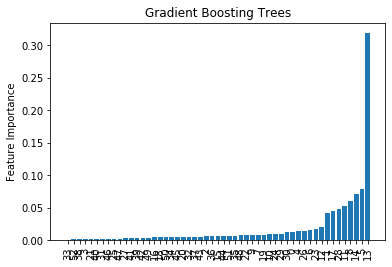

In [102]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_gbt)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_gbt, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Gradient Boosting Trees: Overall")
plt.show()

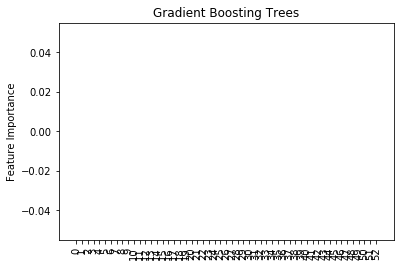

In [103]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_gbt_pre)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_gbt_pre, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Gradient Boosting Trees: Pre Feb")
plt.show()

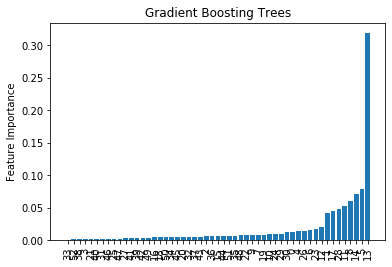

In [106]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_gbt_post)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_gbt_post, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Gradient Boosting Trees: Post Feb")
plt.show()

#### Random Forests

In [116]:
final_models_rf = [RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=10, max_depth=10),
                   RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=200, max_depth=5),
                   RandomForestRegressor(criterion='mse', bootstrap=True, n_estimators=100, max_depth=5)]
x_list = [group1_x, group2_x, group4_x]
y_list = [group1_y, group2_y, group4_y]

In [172]:
window_length = 90
k = 0

final_model_rf = final_models_rf[k]
x = x_list[k]
y = y_list[k]
n_windows = x.shape[0] - window_length
n_predictors = y.shape[1]-1
n_covariates = x.shape[1]-1

feature_imp_rf = []
for i in range(n_windows):
    x_data = x.iloc[i:(i+window_length), 1:]
    y_data = y.iloc[i:(i+window_length), 1:]

    final_model_rf.fit(x_data, y_data)
    feature_imp_rf.append(final_model_rf.feature_importances_)

In [173]:
avg_feature_imp_rf = np.mean(feature_imp_rf, axis=0)
avg_feature_imp_rf = avg_feature_imp_rf/sum(avg_feature_imp_rf)

avg_feature_imp_rf_pre = np.mean(feature_imp_rf[0:62], axis=0)
if sum(avg_feature_imp_rf_pre) != 0:
    avg_feature_imp_rf_pre = avg_feature_imp_rf_pre/sum(avg_feature_imp_rf_pre)

avg_feature_imp_rf_post = np.mean(feature_imp_rf[62:], axis=0)
avg_feature_imp_rf_post = avg_feature_imp_rf_post/sum(avg_feature_imp_rf_post)

In [174]:
sorted_barplot_labels_rf = [x for _, x in sorted(zip(avg_feature_imp_rf, range(n_covariates)))]
sorted_barplot_labels_rf_pre = [x for _, x in sorted(zip(avg_feature_imp_rf_pre, range(n_covariates)))]
sorted_barplot_labels_rf_post = [x for _, x in sorted(zip(avg_feature_imp_rf_post, range(n_covariates)))]

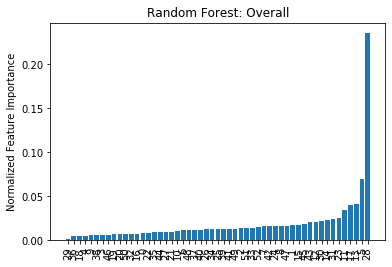

In [175]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_rf)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_rf, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Random Forest: Overall")
plt.show()

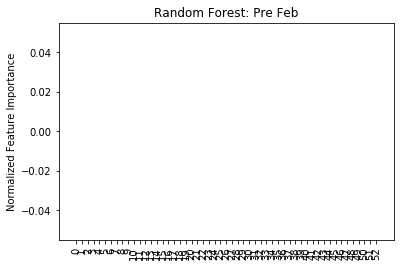

In [176]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_rf_pre)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_rf_pre, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Random Forest: Pre Feb")
plt.show()

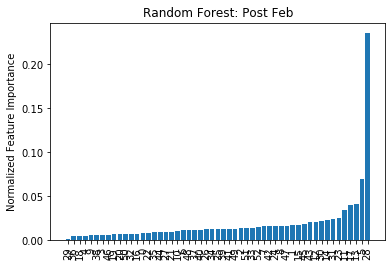

In [177]:
plt.bar(np.arange(n_covariates), list(sorted(avg_feature_imp_rf_post)))
plt.xticks(np.arange(n_covariates), sorted_barplot_labels_rf_post, rotation='vertical')
plt.ylabel("Normalized Feature Importance")
plt.title("Random Forest: Post Feb")
plt.show()

In [180]:
groups = [[3, 4, 5, 8, 9, 20, 21, 22, 23, 24, 26],
          [1, 2, 6, 7, 11, 12, 15, 25, 27, 29, 31],
          [10, 13, 14, 16, 17, 19, 30]] # 1 indexed
for key in groups[k]:
    print([i for i in range(len(sorted_barplot_labels_rf)) if sorted_barplot_labels_rf[i]==key-1][0])

30
6
3
34
37
8
9
18
14
47
26
